# Magnet-Mode Module: Oracle Damping, Clamping, and Price Adjustment Simulation

This notebook simulates and analyzes the Magnet-Mode module's price anchor adjustment based on oracle price deviation. It covers:
- Damping and clamping logic
- Price deviation and convergence
- Edge and boundary conditions
- Fuzz/randomized tests
- Parameter sensitivity
- Economic intuition and visualizations
- Integration and repeated adjustment scenarios

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="whitegrid")

## Core Logic: Damping, Clamping, and Deviation

The module updates AMM price anchors toward the oracle price using a damped adjustment, with a maximum allowed shift per update. All values are scaled by `SCALE` (default 1000).

- Damping: `new = ((SCALE - ALPHA) * current + ALPHA * oracle) // SCALE`
- Clamping: `max_up = (current * (SCALE + MAX_DELTA)) // SCALE`, `max_down = (current * (SCALE - MAX_DELTA)) // SCALE`, `clamped = min(max(new, max_down), max_up)`
- Deviation: `deviation = abs(current - oracle) * SCALE // oracle`

In [18]:
SCALE = 1000
ALPHA = 100   # 0.1 damping factor (scaled)
MAX_DELTA = 50  # 5% max shift (scaled)

def damp(current, oracle, alpha=ALPHA, scale=SCALE):
    return ((scale - alpha) * current + alpha * oracle) // scale

def clamp_shift(new, current, max_delta=MAX_DELTA, scale=SCALE):
    max_up = (current * (scale + max_delta)) // scale
    max_down = (current * (scale - max_delta)) // scale
    return min(max(new, max_down), max_up)

def magnet_mode_update(current, oracle, alpha=ALPHA, max_delta=MAX_DELTA, scale=SCALE):
    damped = damp(current, oracle, alpha, scale)
    return clamp_shift(damped, current, max_delta, scale)

def deviation(current, oracle, scale=SCALE):
    return abs(current - oracle) * scale // oracle if oracle != 0 else 0

## Example Scenarios: Damping, Clamping, and Deviation

Explore price updates for a variety of oracle deviations, including edge and boundary cases.

In [19]:
BASE_PRICE = 1000
ORACLE_PRICE_LOW = 950
ORACLE_PRICE_HIGH = 1050
ORACLE_PRICE_EXTREME_LOW = 800
ORACLE_PRICE_EXTREME_HIGH = 1200

scenarios = [
    (BASE_PRICE, BASE_PRICE, "No deviation"),
    (BASE_PRICE, ORACLE_PRICE_HIGH, "+5% oracle"),
    (BASE_PRICE, ORACLE_PRICE_LOW, "-5% oracle"),
    (BASE_PRICE, ORACLE_PRICE_EXTREME_HIGH, "+20% oracle"),
    (BASE_PRICE, ORACLE_PRICE_EXTREME_LOW, "-20% oracle"),
    (1200, 1100, "Current above oracle"),
    (800, 900, "Current below oracle"),
]

results = []
for current, oracle, label in scenarios:
    damped = damp(current, oracle)
    clamped = magnet_mode_update(current, oracle)
    dev = deviation(current, oracle)
    results.append({
        "Scenario": label,
        "Current": current,
        "Oracle": oracle,
        "Damped": damped,
        "Final (Clamped)": clamped,
        "Deviation (%)": dev / 10
    })
pd.DataFrame(results)

,Scenario,Current,Oracle,Damped,Final (Clamped),Deviation (%)
0,No deviation,1000,1000,1000,1000,0.0
1,+5% oracle,1000,1050,1005,1005,4.7
2,-5% oracle,1000,950,995,995,5.2
3,+20% oracle,1000,1200,1020,1020,16.6
4,-20% oracle,1000,800,980,980,25.0
5,Current above oracle,1200,1100,1190,1190,9.0
6,Current below oracle,800,900,810,810,11.1


## Visualize Damping, Clamping, and Deviation Across Oracle Range

For a fixed current price, plot the damped, clamped, and deviation values as the oracle price varies.

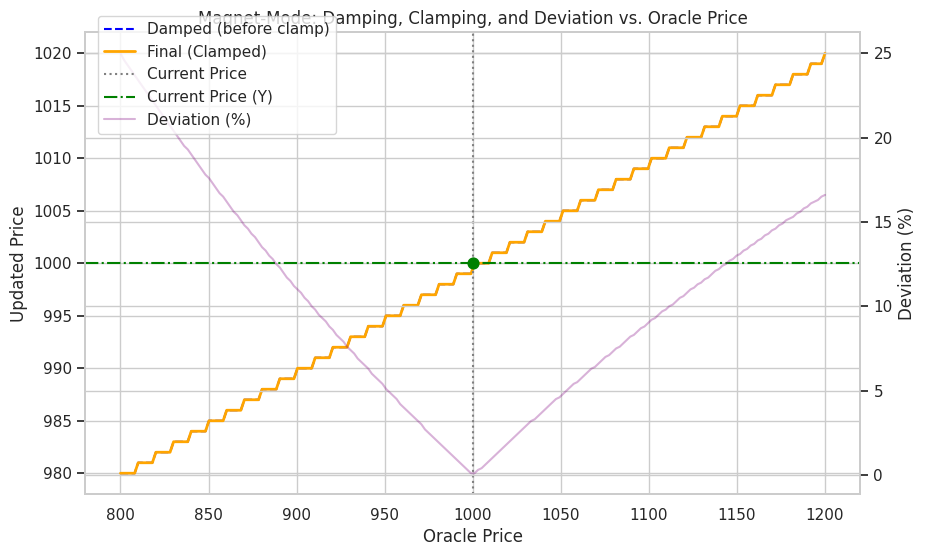

In [20]:
current = 1000
oracle_range = np.linspace(800, 1200, 200)
damped = [damp(current, o) for o in oracle_range]
clamped = [magnet_mode_update(current, o) for o in oracle_range]
devs = [deviation(current, o) / 10 for o in oracle_range]

fig, ax1 = plt.subplots(figsize=(10,6))
ax1.plot(oracle_range, damped, label="Damped (before clamp)", linestyle='--', color='blue')
ax1.plot(oracle_range, clamped, label="Final (Clamped)", linewidth=2, color='orange')
ax1.axvline(current, color='gray', linestyle=':', label='Current Price')
ax1.axhline(current, color='green', linestyle='-.', label='Current Price (Y)')
ax1.scatter([current], [current], color='green', s=60, zorder=5)
ax1.set_xlabel('Oracle Price')
ax1.set_ylabel('Updated Price')
ax1.set_title('Magnet-Mode: Damping, Clamping, and Deviation vs. Oracle Price')
ax2 = ax1.twinx()
ax2.plot(oracle_range, devs, color='purple', alpha=0.3, label='Deviation (%)')
ax2.set_ylabel('Deviation (%)')
fig.legend(loc='upper left', bbox_to_anchor=(0.13,0.92))
plt.show()

## Repeated Updates: Convergence and Clamping

Simulate repeated updates toward a fixed oracle, showing how clamping limits the speed of convergence. Also plot the theoretical (unclamped) damping for comparison.

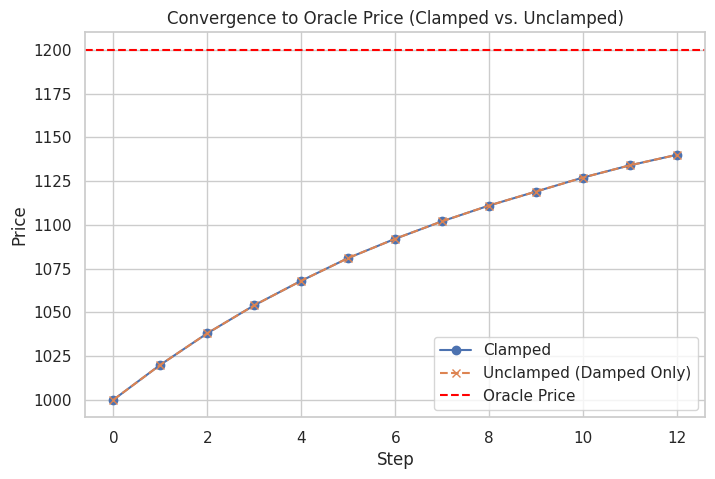

In [21]:
oracle = 1200
current = 1000
steps = 12
history = [current]
history_unclamped = [current]
for _ in range(steps):
    current = magnet_mode_update(current, oracle)
    history.append(current)
    current_unclamped = damp(history_unclamped[-1], oracle)
    history_unclamped.append(current_unclamped)

plt.figure(figsize=(8,5))
plt.plot(history, marker='o', label='Clamped')
plt.plot(history_unclamped, marker='x', linestyle='--', label='Unclamped (Damped Only)')
plt.axhline(oracle, color='red', linestyle='--', label='Oracle Price')
plt.xlabel('Step')
plt.ylabel('Price')
plt.title('Convergence to Oracle Price (Clamped vs. Unclamped)')
plt.legend()
plt.show()

## Edge and Boundary Tests

Test the contract's boundary logic: max allowed up/down shift, and that the price never overshoots the clamp.

In [22]:
max_upshift = (BASE_PRICE * (SCALE + MAX_DELTA)) // SCALE
max_downshift = (BASE_PRICE * (SCALE - MAX_DELTA)) // SCALE

oracle_at_max_up = max_upshift
oracle_at_max_down = max_downshift

up = magnet_mode_update(BASE_PRICE, oracle_at_max_up)
down = magnet_mode_update(BASE_PRICE, oracle_at_max_down)

print(f"Max upshift allowed: {max_upshift}, result: {up}")
print(f"Max downshift allowed: {max_downshift}, result: {down}")

assert up <= max_upshift
assert down >= max_downshift

Max upshift allowed: 1050, result: 1005
Max downshift allowed: 950, result: 995


## Fuzz/Randomized Test: Clamp Always Holds

Test that the updated price never moves more than 5% from the current price in one step, for random oracle/current pairs.

In [23]:
np.random.seed(42)
num_tests = 2000
current_prices = np.random.randint(800, 1200, num_tests)
oracle_prices = np.random.randint(800, 1200, num_tests)

violations = 0
for c, o in zip(current_prices, oracle_prices):
    updated = magnet_mode_update(c, o)
    max_up = (c * (SCALE + MAX_DELTA)) // SCALE
    max_down = (c * (SCALE - MAX_DELTA)) // SCALE
    if not (max_down <= updated <= max_up):
        violations += 1
print(f"Violations of clamp: {violations} out of {num_tests}")
assert violations == 0

Violations of clamp: 0 out of 2000


## Parameter Sensitivity: Damping and Max Delta

Visualize how changing `ALPHA` (damping) and `MAX_DELTA` (clamp) affects the update step, and the speed of convergence.

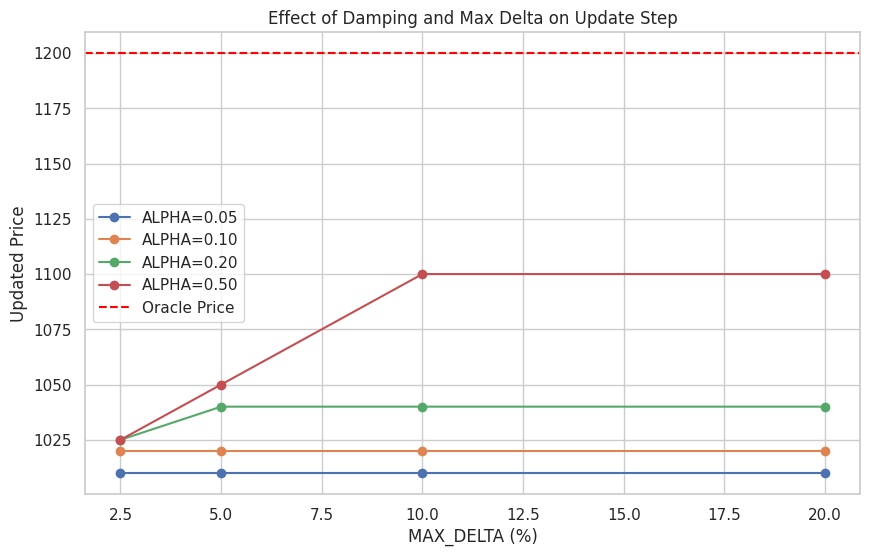

In [24]:
current = 1000
oracle = 1200
alphas = [50, 100, 200, 500]  # 0.05, 0.1, 0.2, 0.5
max_deltas = [25, 50, 100, 200]  # 2.5%, 5%, 10%, 20%

plt.figure(figsize=(10,6))
for alpha in alphas:
    updated = []
    for max_delta in max_deltas:
        val = magnet_mode_update(current, oracle, alpha=alpha, max_delta=max_delta)
        updated.append(val)
    plt.plot([md/10 for md in max_deltas], updated, marker='o', label=f'ALPHA={alpha/1000:.2f}')
plt.axhline(oracle, color='red', linestyle='--', label='Oracle Price')
plt.xlabel('MAX_DELTA (%)')
plt.ylabel('Updated Price')
plt.title('Effect of Damping and Max Delta on Update Step')
plt.legend()
plt.show()

## Economic Intuition and Integration Scenario

- Damping ensures that price anchors move gradually toward the oracle, allowing arbitrageurs to correct small deviations but not exploit large, sudden shifts.
- Clamping prevents manipulation or oracle errors from causing extreme price moves in a single update.
- The combination provides a balance between market responsiveness and protocol safety.

### Integration/Repeated Adjustment Simulation

Simulate a scenario where the oracle price jumps, then returns to normal, and observe the AMM's anchor response.

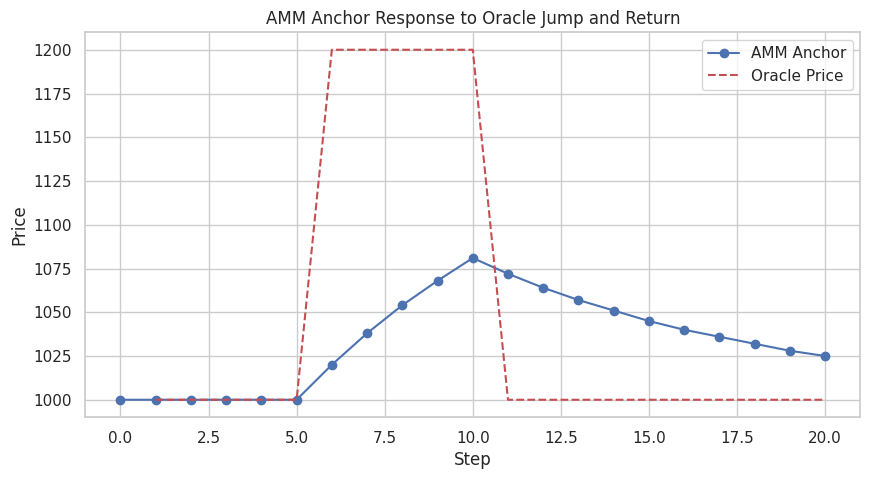

In [25]:
steps = 20
oracle_series = [1000]*5 + [1200]*5 + [1000]*10
current = 1000
history = [current]
for o in oracle_series:
    current = magnet_mode_update(current, o)
    history.append(current)
plt.figure(figsize=(10,5))
plt.plot(history, marker='o', label='AMM Anchor')
plt.plot(range(1, len(oracle_series)+1), oracle_series, 'r--', label='Oracle Price')
plt.xlabel('Step')
plt.ylabel('Price')
plt.title('AMM Anchor Response to Oracle Jump and Return')
plt.legend()
plt.show()